In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: UNRATE

In [5]:
data = pd.read_csv('UNRATE (1).csv', header = None)
data.columns = ['Month','Rate']
data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head()

,Rate
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [6]:
data.shape

(867, 1)

In [7]:
data.isnull().sum()

Rate    0
dtype: int64

# Time series analysis
## Plot time series data

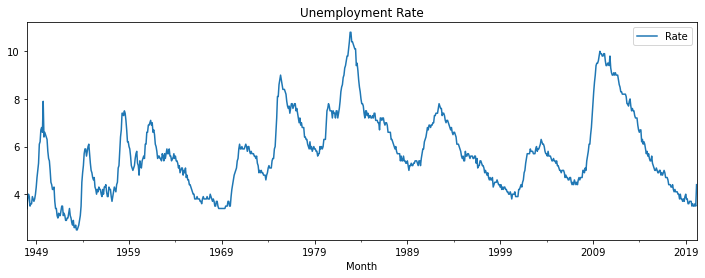

In [8]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Unemployment Rate')
plt.show(block=False)

## Split time series data into training and test set

In [9]:
train_len = 612
train = data[0:train_len] # first 612 months as training set
test = data[train_len:] # last 255 months as out-of-time test set

# Auto Regressive methods

### Augmented Dickey-Fuller (ADF) test

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Rate'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.143963
Critical Values @ 0.05: -2.86
p-value: 0.023466


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [11]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Rate'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.464446
Critical Values @ 0.05: 0.46
p-value: 0.049674


### Box Cox transformation to make variance constant

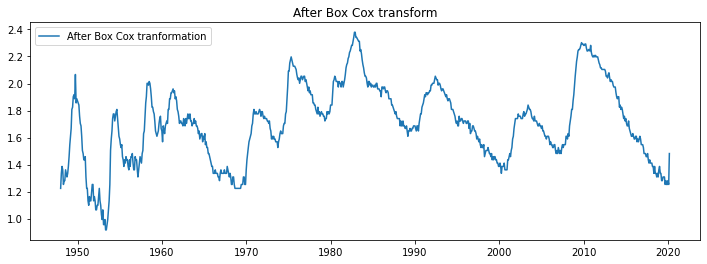

In [12]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Rate'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

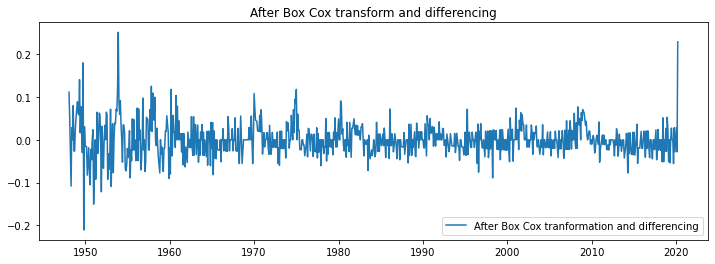

In [13]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [14]:
data_boxcox_diff.dropna(inplace=True)

In [15]:
data_boxcox_diff.tail()

Month
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

### ADF Test

In [16]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.918955
Critical Values @ 0.05: -2.86
p-value: 0.000000


### KPSS Test

In [17]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.062761
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Autocorrelation function (ACF)

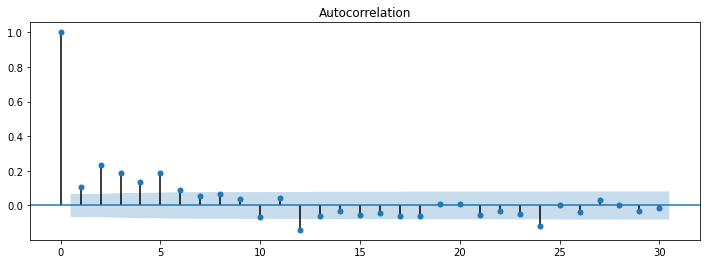

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

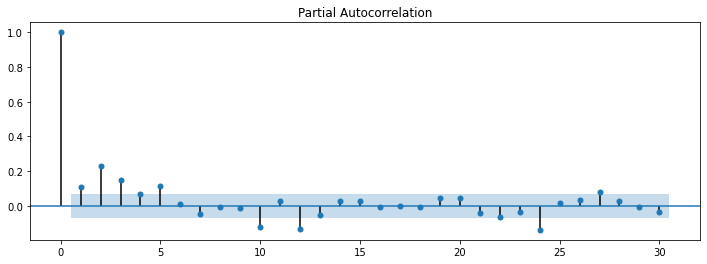

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [20]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [21]:
train_data_boxcox_diff.head()

Month
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
dtype: float64

## Auto regression method (AR)

In [22]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090455
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


In [28]:
len(train_data_boxcox_diff)

611

In [23]:
model_fit.predict(start=len(train_data_boxcox_diff), end=len(train_data_boxcox_diff)+len(test_data_boxcox_diff)-1, dynamic=False)

1999-01-01   -0.003882
1999-02-01    0.010749
1999-03-01   -0.013977
1999-04-01    0.008995
1999-05-01   -0.001653
                ...   
2019-11-01    0.000466
2019-12-01    0.000466
2020-01-01    0.000466
2020-02-01    0.000466
2020-03-01    0.000466
Freq: MS, Length: 255, dtype: float64

### Recover original time series

In [24]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

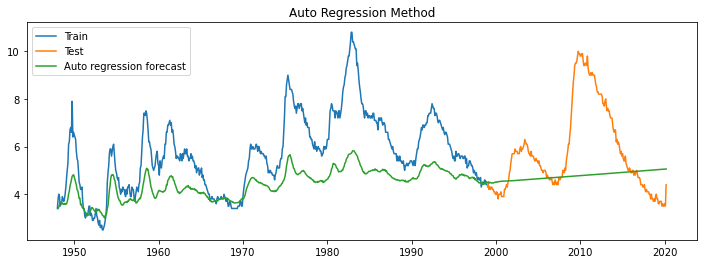

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_ar['ar_forecast'], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [26]:
y_hat_ar['ar_forecast']

1948-02-01    3.401586
1948-03-01    3.453112
1948-04-01    3.559367
1948-05-01    3.651090
1948-06-01    3.670434
                ...   
2019-11-01    5.049045
2019-12-01    5.051401
2020-01-01    5.053757
2020-02-01    5.056114
2020-03-01    5.058473
Freq: MS, Length: 866, dtype: float64

In [27]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_ar['ar_forecast'][test.index.min():])/test['Rate'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.5


## Moving average method (MA)

In [72]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [73]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

In [74]:
y_hat_ma['ma_forecast']

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
                ...   
2019-11-01    5.921776
2019-12-01    5.924781
2020-01-01    5.927789
2020-02-01    5.930797
2020-03-01    5.933808
Freq: MS, Length: 866, dtype: float64

## Auto regressive integrated moving average (ARIMA)

In [57]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

const         0.000458
ar.L1.D.y    -0.220889
ar.L2.D.y     0.756848
ar.L3.D.y     0.553757
ar.L4.D.y    -0.506903
ar.L5.D.y    -0.654034
ar.L6.D.y     0.058309
ar.L7.D.y     0.050170
ar.L8.D.y     0.101922
ar.L9.D.y     0.159699
ar.L10.D.y   -0.046601
ar.L11.D.y   -0.025743
ar.L12.D.y   -0.050402
ma.L1.D.y     0.250318
ma.L2.D.y    -0.594492
ma.L3.D.y    -0.410138
ma.L4.D.y     0.560173
ma.L5.D.y     0.719714
dtype: float64


In [58]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

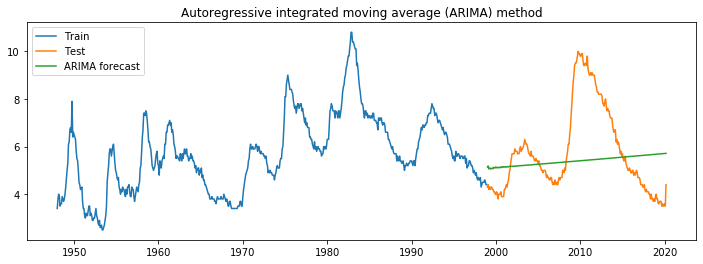

In [59]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [60]:
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_arima['arima_forecast'][test.index.min():])/test['Rate'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Autoregressive integrated moving average (ARIM...,1.85,23.23


## Seasonal auto regressive integrated moving average (SARIMA)

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.598652
ar.L2       0.121533
ma.L1      -0.560886
ma.L2      -0.005359
ma.L3       0.068107
ma.L4       0.054699
ar.S.L12   -0.936120
ar.S.L24   -0.510952
ma.S.L12   -0.279394
ma.S.L24   -0.538431
ma.S.L36   -0.397994
ma.S.L48    0.269891
sigma2      0.001494
dtype: float64


In [62]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

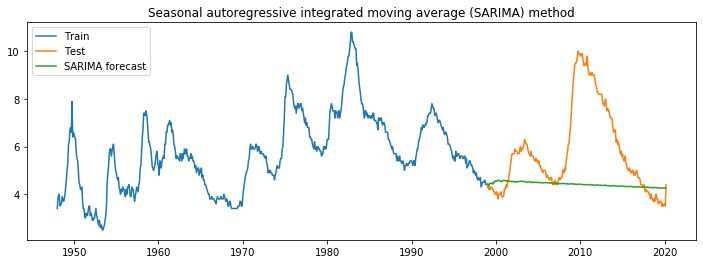

In [63]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [64]:
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Rate'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Autoregressive integrated moving average (ARIM...,1.85,23.23
0,Seasonal autoregressive integrated moving aver...,2.26,22.17
